<a href="https://colab.research.google.com/github/aeidablu/Frieght_cost_prediction_using_timeseries/blob/main/Freightcost_prediction_using_Time_Series_Analysis_with_ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg



# Prepare Data

## Import data

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath)

  # Convert 'Delivery Recorded Date' to datetime and 'Freight Cost (USD)' to int64
  df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])
  # Handle non-numeric values in 'Freight Cost (USD)'
  df['Freight Cost (USD)']=pd.to_numeric(df['Freight Cost (USD)'], errors='coerce')
  # Now convert to int 64, filling NaN with a suitable value (e.g, 0)
  df['Freight Cost (USD)']= df['Freight Cost (USD)'].fillna(0).astype('int64')

  # Remove outliers
  low, high = df['Freight Cost (USD)'].quantile([0.25, 0.85])
  mask_area = df['Freight Cost (USD)'].between(low, high)
  df_cleaned = df[mask_area]

  # Set Delivery Record Date as the index for the time series analysis
  df_cleaned.set_index("Delivery Recorded Date", inplace= True)

  # Remove zero values
  zero_count = (df_cleaned['Freight Cost (USD)'] == 0).sum()
  df_cleaned = df_cleaned[df_cleaned['Freight Cost (USD)'] != 0]

  # Aggregate the data on a monthly basis
  df_cleaned_monthly = df_cleaned['Freight Cost (USD)'].resample('M').mean()
  y = df_cleaned_monthly.dropna()

  return y, df_cleaned, df

In [ ]:
y, df_cleaned, df = wrangle('SCMS_Delivery_History_Dataset.csv')
df_cleaned.head()

## Explore Data

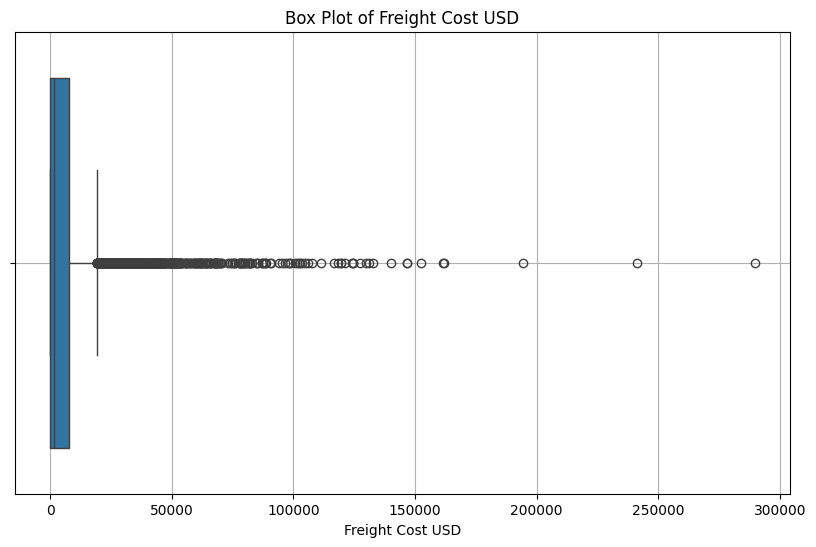

In [7]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Freight Cost (USD)', data=df)
plt.title('Box Plot of Freight Cost USD')
plt.xlabel('Freight Cost USD')
plt.grid(True)
plt.show()

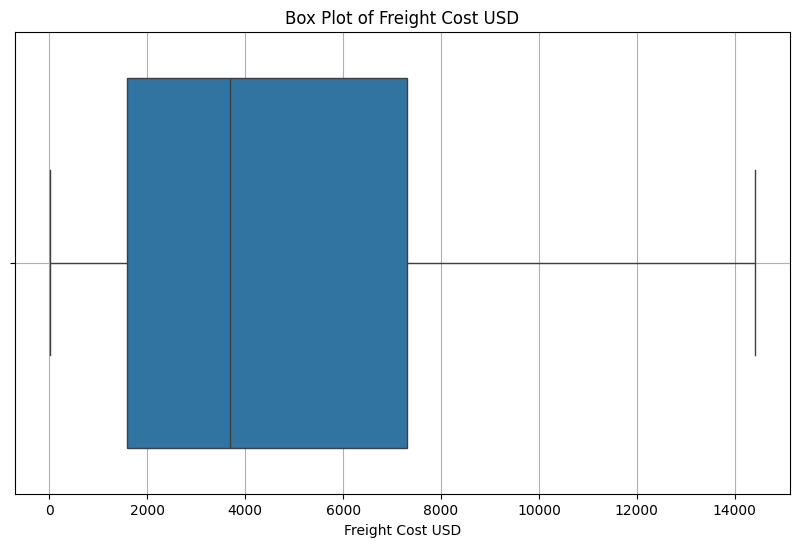

In [8]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Freight Cost (USD)', data=df_cleaned)
plt.title('Box Plot of Freight Cost USD')
plt.xlabel('Freight Cost USD')
plt.grid(True)
plt.show()

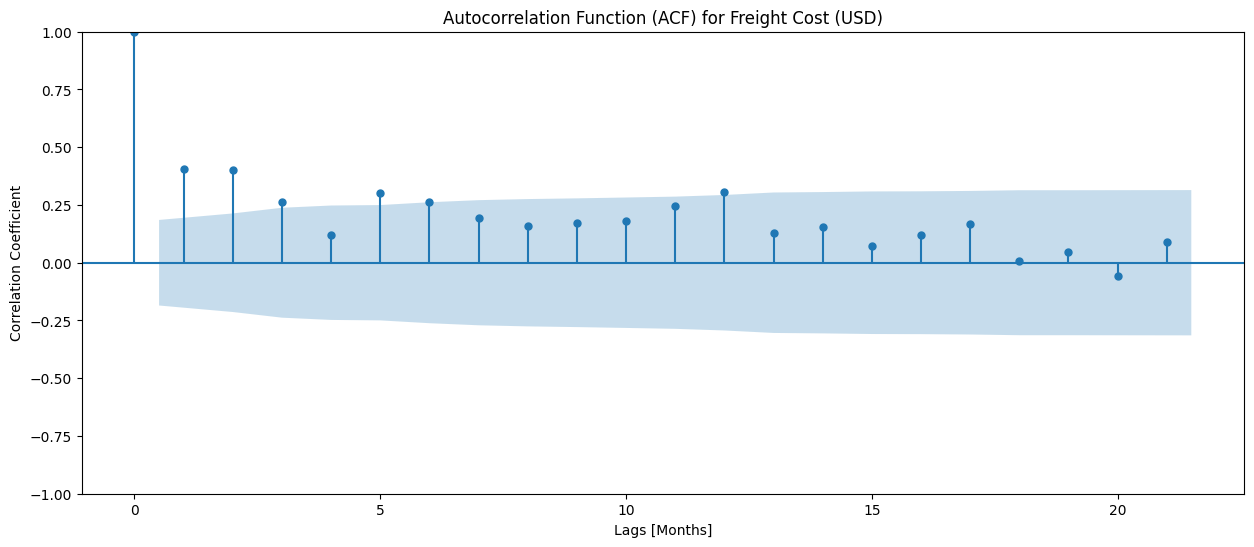

In [9]:
# Plot ACF
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel('Lags [Months]')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation Function (ACF) for Freight Cost (USD)')
plt.show()

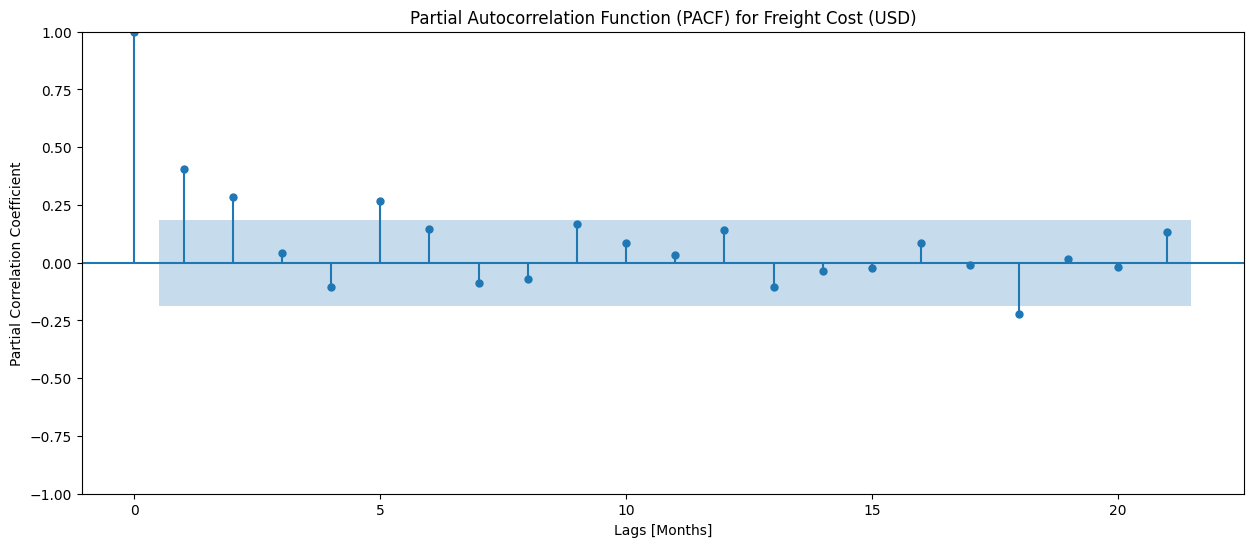

In [10]:
# Plot PACF
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel('Lags [Months]')
plt.ylabel('Partial Correlation Coefficient')
plt.title('Partial Autocorrelation Function (PACF) for Freight Cost (USD)')
plt.show()

## Split

In [11]:
# Split data into test and training set
cutoff_test = int(len(y) * 0.90)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

# Build Model

## Baseline

In [12]:
# Calculate the baseline mean absolute error of model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 reading:",  round(y_train_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean P2 reading: 4564.22
Baseline MAE: 904.96


In [13]:
# Create ranges for possible $p$ and $q$ values. `p_params` should range between 0 and 20, by steps of 7. `q_params` should range between 0 and 3 by steps of 1.

p_params = range(0, 18, 4)
q_params = range(0, 3, 1)

In [ ]:
list(p_params)

[0, 4, 8, 12, 16]

In [14]:
# Create an empty dictionary for MAE values
mae_grid = {}
for p in p_params:
  # Create new key in dictionary with empty list
  mae_grid[p] = []
  for q in q_params:
    # Set the hyperparameters for the model
    order = (p, 0, q)
    # Start timing
    start_time = time.time()
    # Train model
    model = ARIMA(y_train, order=order).fit()
    # Calculate elapsed time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained ARIMA model {order} in {elapsed_time} seconds.")
    # Generate in-sample predictions
    y_pred = model.predict()
    # Calculate training MAE
    mae = mean_absolute_error(y_train, y_pred)
    # Add MAE to dictionary
    mae_grid[p].append(mae)


Trained ARIMA model (0, 0, 0) in 0.13 seconds.
Trained ARIMA model (0, 0, 1) in 0.09 seconds.
Trained ARIMA model (0, 0, 2) in 0.14 seconds.
Trained ARIMA model (4, 0, 0) in 0.22 seconds.
Trained ARIMA model (4, 0, 1) in 0.36 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (4, 0, 2) in 0.49 seconds.
Trained ARIMA model (8, 0, 0) in 0.61 seconds.
Trained ARIMA model (8, 0, 1) in 0.6 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (8, 0, 2) in 1.2 seconds.
Trained ARIMA model (12, 0, 0) in 3.06 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (12, 0, 1) in 1.59 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (12, 0, 2) in 1.48 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (16, 0, 0) in 2.18 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA model (16, 0, 1) in 2.04 seconds.
Trained ARIMA model (16, 0, 2) in 2.13 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
# Train a model with every combination of hyperparameters in p_params and q_params. Every time the model is trained, the mean absolute error is calculated and then saved to a dictionary

mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)


,0,4,8,12,16
0,904.9599,781.4486,728.0783,696.5904,684.0087
1,873.1712,776.7267,725.1756,691.8036,682.1654
2,784.5118,755.3323,713.6234,686.6074,676.5623


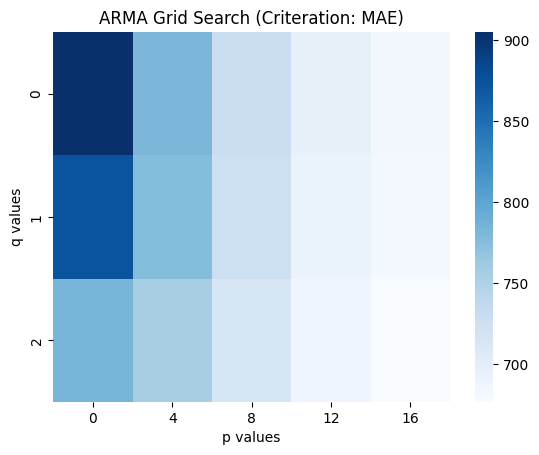

In [16]:
# Create heatmap of the values in mae_grid
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criteration: MAE)");

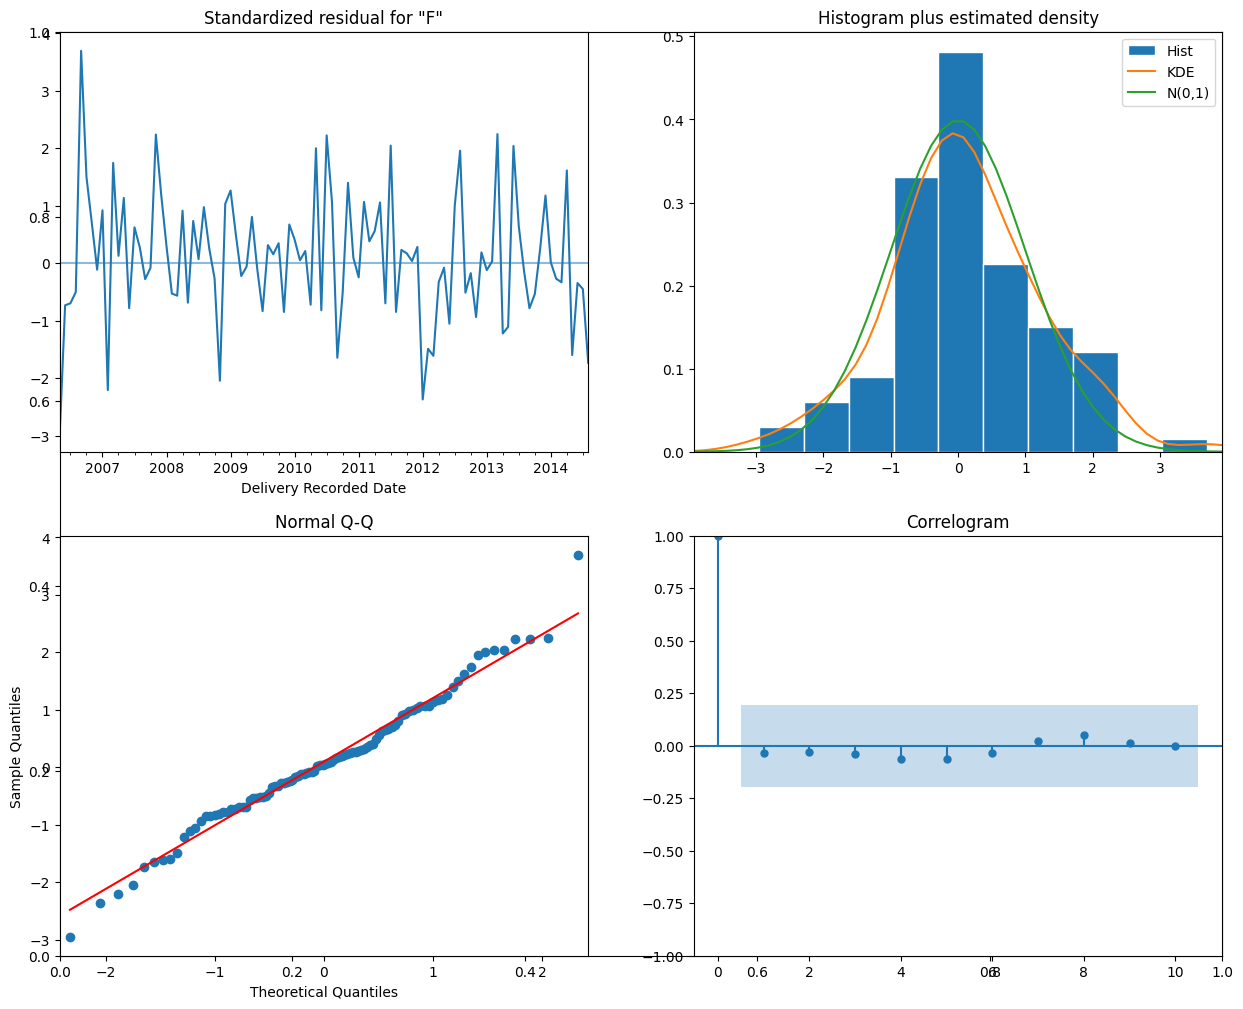

In [17]:
# Use the plot_diagnostics method to check the residuals for your model. Keep in mind that the plot will represent the residuals from the last model you trained, so make sure it was your best model, too!

fig, ax = plt.subplots(figsize = (15,12))
model.plot_diagnostics(fig=fig);

## Evaluate

In [20]:
# Perform walk-forward validation for model for the entire test set y_test. Store model's predictions in the Series y_pred_wfv. Choose the values for  𝑝 and  𝑞
#  that best balance model performance and computation time.

y_pred_wfv = []  # Initialize as a list
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(16,0,2)).fit()
    next_pred = model.forecast()
    y_pred_wfv.extend(next_pred)  # Use extend to add elements to the list
    # Use pd.concat to append the next prediction to the history
    history = pd.concat([history, y_test[next_pred.index]])

# Convert the list to a Series after the loop
y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [21]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE:", round(test_mae, 2))

Test MAE: 676.67


# Communicate Results

In [22]:
# Generate the list of training predictions for your model. Next, create a DataFrame df_predictions with the true values y_test and your predictions y_pred_wfv (don't forget the index). Finally, plot df_predictions using plotly express.

df_predictions = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
    }
)
fig = px.line(df_predictions)
fig.show()